In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import re
import gensim
import string
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
# Configure Matplotlib
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

# Stop Words
stop_words = set(stopwords.words('english'))

# Tokenizing
from nltk import word_tokenize, sent_tokenize

# Other imports
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict, Counter
from sklearn.decomposition import PCA, TruncatedSVD
from wordcloud import WordCloud
from gensim import corpora, models
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
#
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# Backend Configuration
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


### data exploration

In [2]:
# We load the data 
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df=pd.concat([train_data,test_data]) # 10,876 rows and 5 columns.
df.shape

(10876, 5)

In [4]:
# Get some basic info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### data cleaning

In [6]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [7]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [9]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))

In [10]:
def create_corpus_df(train_data,test_data):
    corpus=[]
    
    for x in train_data[train_data['target']==test_data]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
corpus_new1=create_corpus_df(df,1)
len(corpus_new1) # this corpus consists of 48,780 text documents or samples. 

48780

In [12]:
sample_corpora = df['text'].iloc[:2].values
sample_corpora

array(['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask Canada'], dtype=object)

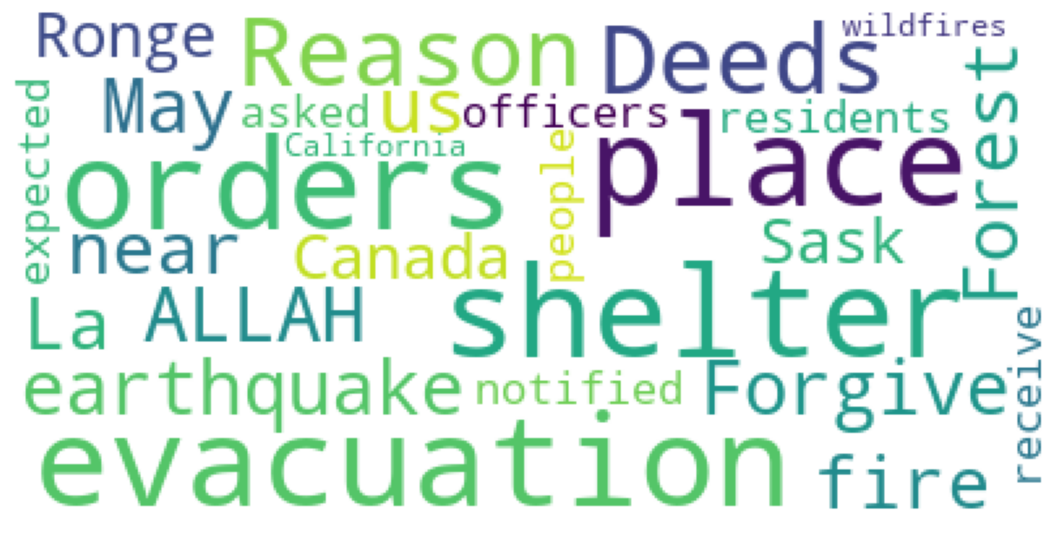

In [44]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 50
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### build models

#### TF-IDF

In [14]:
# A numerical representation of how important a term is in a specific document relative to its importance in the entire corpus. 
# Import TfidfVectorizer

trainX, testX, trainy, testy = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)  
tv_train = tv.fit_transform(trainX)
tv_test = tv.transform(testX)

# Train a classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(tv_train, trainy)

# Predict on the test set
y_pred = clf.predict(tv_test)

# Calculate accuracy
accuracy = accuracy_score(testy, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


In [15]:
tfidf_vectorizer = TfidfVectorizer() 
tfidf_train_vectors = tfidf_vectorizer.fit_transform(trainX)
tfidf_test_vectors = tfidf_vectorizer.transform(testX)

In [16]:
classifier = RandomForestClassifier()
classifier.fit(tfidf_train_vectors,trainy)

RandomForestClassifier()

In [17]:
y_pred = classifier.predict(tfidf_test_vectors)

In [18]:
print(classification_report(testy,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.93      0.83       874
           1       0.86      0.60      0.71       649

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523



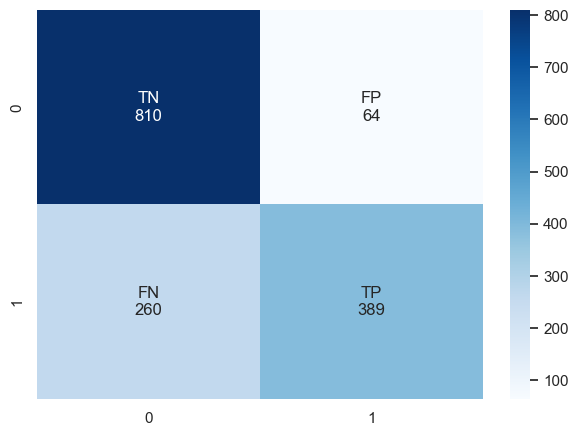

In [19]:
cnf_matrix = confusion_matrix(testy,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [20]:
# export the data
tfidf_test_vectors = tfidf_vectorizer.transform(test_data['text'])  # Use the entire test data
# Predict on the test set
y_pred = clf.predict(tfidf_test_vectors)
# Create a DataFrame with 'id' and 'target' columns
test_result_df = pd.DataFrame({'id': test_data['id'], 'target': y_pred})
# Save the DataFrame as a CSV file
test_result_df.to_csv('tf_predictions.csv', index=False)

#### basic deep learning model keras package

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create another TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()  # Convert to dense NumPy array

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()  # Convert to dense NumPy array

# Create a basic neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_tfidf, to_categorical(y_train_encoded), epochs=10, batch_size=32, validation_data=(X_test_tfidf, to_categorical(y_test_encoded)))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_tfidf, to_categorical(y_test_encoded))
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
272/272 [==============================] - 3s 11ms/step - loss: 1.0413 - accuracy: 0.4705 - val_loss: 0.9480 - val_accuracy: 0.5524
Epoch 2/10
272/272 [==============================] - 2s 8ms/step - loss: 0.8694 - accuracy: 0.6098 - val_loss: 0.9441 - val_accuracy: 0.5441
Epoch 3/10
272/272 [==============================] - 2s 8ms/step - loss: 0.6894 - accuracy: 0.7082 - val_loss: 1.0591 - val_accuracy: 0.5106
Epoch 4/10
272/272 [==============================] - 2s 8ms/step - loss: 0.5174 - accuracy: 0.7995 - val_loss: 1.2520 - val_accuracy: 0.4646
Epoch 5/10
272/272 [==============================] - 2s 7ms/step - loss: 0.4008 - accuracy: 0.8597 - val_loss: 1.3726 - val_accuracy: 0.4733
Epoch 6/10
272/272 [==============================] - 2s 7ms/step - loss: 0.2971 - accuracy: 0.8998 - val_loss: 1.5814 - val_accuracy: 0.4582
Epoch 7/10
272/272 [==============================] - 2s 7ms/step - loss: 0.2279 - accuracy: 0.9256 - val_loss: 1.7329 - val_accuracy: 0.4674
Epoch

In [22]:
# Transform the new data using the TF-IDF vectorizer
new_data_tfidf = tfidf_vectorizer.transform(test_data['text']).toarray()

# Make predictions on the new data
new_data_predictions = model.predict(new_data_tfidf)

# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(np.argmax(new_data_predictions, axis=1))

# Add the predicted labels to the test data DataFrame
test_data['predicted_target'] = predicted_labels

# Save the DataFrame to a CSV file
test_data.to_csv('predicted_data.csv', index=False)


102/102 [==============================] - 2s 3ms/step


In [27]:
# Read the CSV file into a DataFrame
df = pd.read_csv("predicted_data.csv")

In [28]:
# Drop 'keyword' and 'location' columns
df = df.drop(['keyword', 'location','text'], axis=1)

# Rename 'predicted_target' to 'target'
df = df.rename(columns={'predicted_target': 'target'})

# Replace non-finite values (e.g., NaN) in the 'target' column with '0'
df['target'].fillna(0, inplace=True)

# Convert the 'target' column to integers
df['target'] = df['target'].astype(int)

# Save the modified DataFrame to a CSV file
df.to_csv('keras_predicted_data.csv', index=False)


In [ ]:
#-------------------------------------------------------

In [39]:

# Create a basic neural network model, a bit overfitting, 
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model, train 20 times, training examples (samples) is 64
model.fit(X_train_tfidf, to_categorical(y_train_encoded), epochs=20, batch_size=64, validation_data=(X_test_tfidf, to_categorical(y_test_encoded)))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_tfidf, to_categorical(y_test_encoded))
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/20
136/136 [==============================] - 3s 18ms/step - loss: 1.0774 - accuracy: 0.4237 - val_loss: 1.0122 - val_accuracy: 0.5285
Epoch 2/20
136/136 [==============================] - 2s 12ms/step - loss: 0.9296 - accuracy: 0.5683 - val_loss: 0.9363 - val_accuracy: 0.5450
Epoch 3/20
136/136 [==============================] - 2s 11ms/step - loss: 0.7587 - accuracy: 0.6717 - val_loss: 0.9870 - val_accuracy: 0.5496
Epoch 4/20
136/136 [==============================] - 1s 11ms/step - loss: 0.6002 - accuracy: 0.7659 - val_loss: 1.0967 - val_accuracy: 0.5097
Epoch 5/20
136/136 [==============================] - 1s 11ms/step - loss: 0.4491 - accuracy: 0.8385 - val_loss: 1.2454 - val_accuracy: 0.4835
Epoch 6/20
136/136 [==============================] - 2s 12ms/step - loss: 0.3440 - accuracy: 0.8836 - val_loss: 1.4183 - val_accuracy: 0.4738
Epoch 7/20
136/136 [==============================] - 1s 10ms/step - loss: 0.2718 - accuracy: 0.9091 - val_loss: 1.5493 - val_accuracy: 0.4669

In [29]:
# a bit overfitting
#--------------------------------------

In [30]:
# Create a basic neural network model, change dropot to prevent overfitting
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.75),
    Dense(32, activation='relu'),
    Dropout(0.85),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_tfidf, to_categorical(y_train_encoded), epochs=10, batch_size=32, validation_data=(X_test_tfidf, to_categorical(y_test_encoded)))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_tfidf, to_categorical(y_test_encoded))
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
272/272 [==============================] - 3s 11ms/step - loss: 1.0905 - accuracy: 0.3929 - val_loss: 1.0780 - val_accuracy: 0.4067
Epoch 2/10
272/272 [==============================] - 2s 8ms/step - loss: 1.0789 - accuracy: 0.4090 - val_loss: 1.0491 - val_accuracy: 0.4637
Epoch 3/10
272/272 [==============================] - 2s 8ms/step - loss: 1.0409 - accuracy: 0.4468 - val_loss: 0.9957 - val_accuracy: 0.5579
Epoch 4/10
272/272 [==============================] - 2s 8ms/step - loss: 0.9892 - accuracy: 0.4980 - val_loss: 0.9611 - val_accuracy: 0.5556
Epoch 5/10
272/272 [==============================] - 2s 8ms/step - loss: 0.9365 - accuracy: 0.5422 - val_loss: 0.9423 - val_accuracy: 0.5496
Epoch 6/10
272/272 [==============================] - 2s 8ms/step - loss: 0.8989 - accuracy: 0.5726 - val_loss: 0.9465 - val_accuracy: 0.5363
Epoch 7/10
272/272 [==============================] - 2s 8ms/step - loss: 0.8528 - accuracy: 0.5963 - val_loss: 0.9552 - val_accuracy: 0.5262
Epoch

In [31]:
# Transform the new data using the TF-IDF vectorizer
new_data_tfidf = tfidf_vectorizer.transform(test_data['text']).toarray()

# Make predictions on the new data
new_data_predictions = model.predict(new_data_tfidf)

# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(np.argmax(new_data_predictions, axis=1))

# Add the predicted labels to the test data DataFrame
test_data['predicted_target'] = predicted_labels

# Save the DataFrame to a CSV file
test_data.to_csv('predicted_data3.csv', index=False)

102/102 [==============================] - 1s 5ms/step


In [32]:
# Read the CSV file into a DataFrame
df = pd.read_csv("predicted_data3.csv")

In [33]:
# Drop 'keyword' and 'location' columns
df = df.drop(['keyword', 'location','text'], axis=1)

# Rename 'predicted_target' to 'target'
df = df.rename(columns={'predicted_target': 'target'})

# Replace non-finite values (e.g., NaN) in the 'target' column with '0'
df['target'].fillna(0, inplace=True)

# Convert the 'target' column to integers
df['target'] = df['target'].astype(int)

# Save the modified DataFrame to a CSV file
df.to_csv('keras_predicted_data3.csv', index=False)

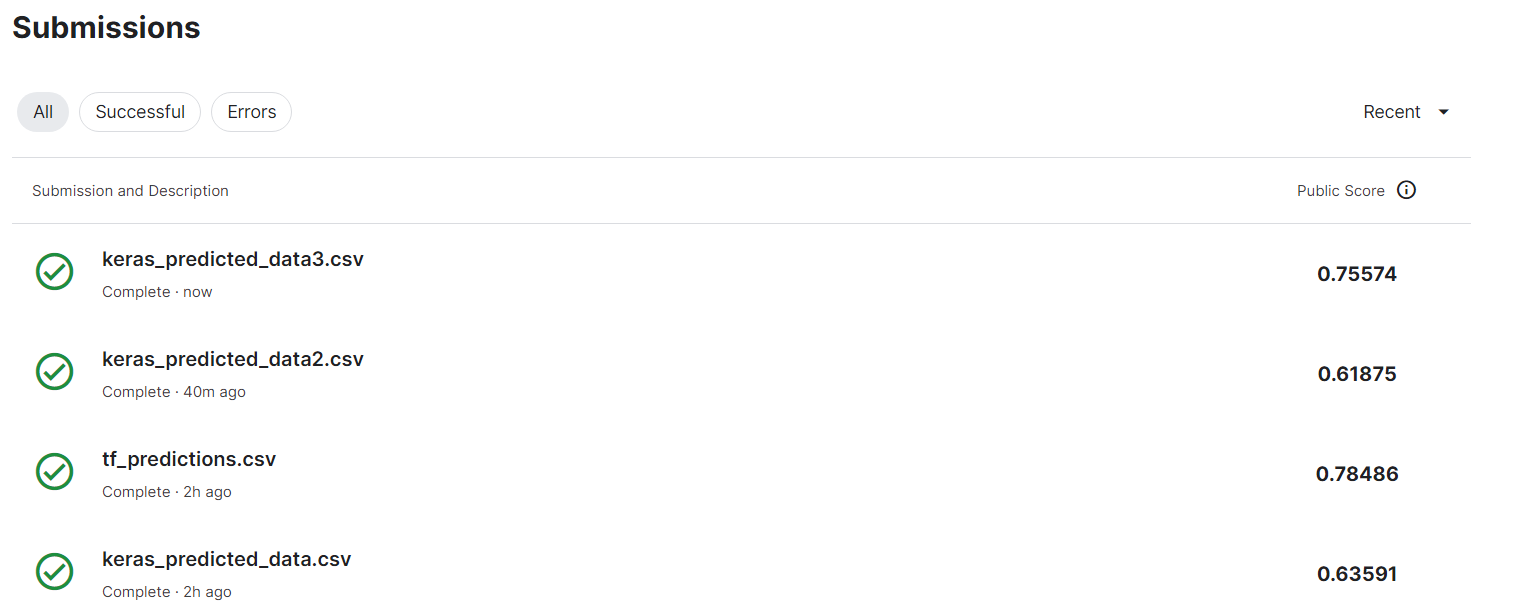

In [37]:
# insert PNG image
from IPython.display import Image
image_path = 'Capture2.png'
# Display the image
Image(filename=image_path)